# Statistical Learning: Bayesian vs Frequentist + Bayesian Inference


This notebook has three parts:
1. **Frequentist vs Bayesian**: a side-by-side comparison using coin toss and normal-mean examples.
2. **Hands-on Bayesian inference**: Beta–Binomial (coin toss) and Normal–Normal (mean with known variance) with visualizations and posterior predictive checks.
3. **Cosmology example**: infer the Hubble constant $H_0$ from synthetic low-$z$ observations using a simple Bayesian model.


### Exercise: As assignment, play around with the code using new values/numbers for various arguments by adding the modified code in new cells at the end of this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
np.random.seed(42)
print('Libraries loaded.')

## Part 1 — Frequentist vs Bayesian: Concepts and Contrasts

We'll contrast **confidence intervals** (Frequentist) with **credible intervals** (Bayesian), and see how interpretations differ. We'll use two simple data-generating processes:
1. **Coin toss** with unknown head probability $p$.
2. **Normal mean** with known variance $\sigma^2$.

### Key ideas to watch for
- **Frequentist CI**: a procedure that (over repeated experiments) contains the true parameter X% of the time.
- **Bayesian credible interval**: given the observed data and prior, there is X% probability that the parameter lies in the interval.

### 1A. Coin toss: Confidence Interval vs Credible Interval

Observed: 75 heads out of 150 (phat = 0.500)
Frequentist 95% Wald CI: [0.420, 0.580]
Bayesian 95% credible interval: [0.421, 0.579]


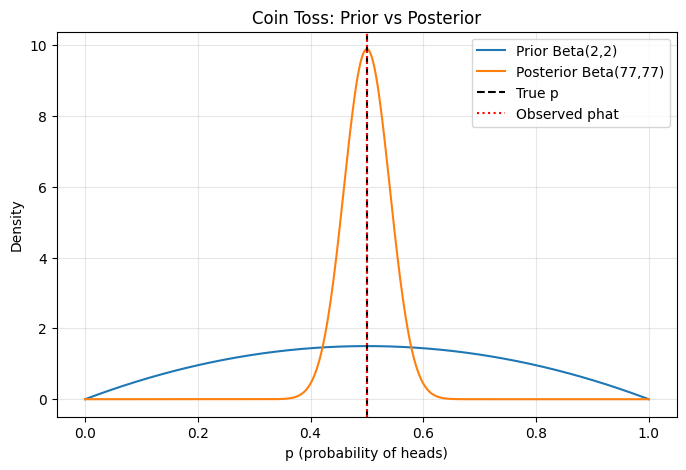

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Coin toss experiment
n = 150                      # number of tosses
p_true = 0.50                # true probability of heads (unknown to the inference procedures)

# Simulate coin tosses
heads = np.random.binomial(n=n, p=p_true)
phat = heads / n
print(f'Observed: {heads} heads out of {n} (phat = {phat:.3f})')

# Frequentist: Wald 95% confidence interval
alpha = 0.05
z = stats.norm.ppf(1 - alpha/2)
se = np.sqrt(phat * (1 - phat) / n)
ci_low = phat - z * se
ci_high = phat + z * se
print(f'Frequentist 95% Wald CI: [{ci_low:.3f}, {ci_high:.3f}]')

# Bayesian: Beta prior + Binomial likelihood -> Beta posterior
alpha_prior, beta_prior = 2.0, 2.0   # Beta(2,2) prior
alpha_post = alpha_prior + heads
beta_post  = beta_prior  + (n - heads)

# 95% credible interval
cred_low, cred_high = stats.beta.ppf([alpha/2, 1 - alpha/2], alpha_post, beta_post)
print(f'Bayesian 95% credible interval: [{cred_low:.3f}, {cred_high:.3f}]')

# Plot prior vs posterior
x = np.linspace(0, 1, 400)
plt.figure(figsize=(8, 5))
plt.plot(x, stats.beta.pdf(x, alpha_prior, beta_prior), label='Prior Beta(2,2)')
plt.plot(x, stats.beta.pdf(x, alpha_post, beta_post), label=f'Posterior Beta({alpha_post:.0f},{beta_post:.0f})')
plt.axvline(p_true, linestyle='--', color='black', label='True p')
plt.axvline(phat, linestyle=':', color='red', label='Observed phat')
plt.title('Coin Toss: Prior vs Posterior')
plt.xlabel('p (probability of heads)')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 1B. Normal mean with known variance: Coverage vs Posterior Probability
We simulate many datasets to show that a 95% Frequentist CI has ~95% **coverage**, while a Bayesian 95% credible interval expresses probability about the parameter given this dataset.

In [6]:
# Normal mean example
mu_true = 1.5
sigma = 1.2                 # known std
n = 40
alpha = 0.05
z = stats.norm.ppf(1 - alpha/2)

# Frequentist single dataset
x = np.random.normal(mu_true, sigma, size=n)
xbar = x.mean()
ci_low = xbar - z * sigma / np.sqrt(n)
ci_high = xbar + z * sigma / np.sqrt(n)
print(f'One dataset: xbar={xbar:.3f}, 95% CI = [{ci_low:.3f}, {ci_high:.3f}]')

# Bayesian: Normal prior on mu with known sigma -> Normal posterior
mu0, tau0 = 0.0, 5.0         # weakly informative prior: mu ~ N(mu0, tau0^2)
post_var = 1 / (1/tau0**2 + n/sigma**2)
post_mean = post_var * (mu0/tau0**2 + n*xbar/sigma**2)
cred_low, cred_high = stats.norm.ppf([alpha/2, 1-alpha/2], loc=post_mean, scale=np.sqrt(post_var))
print(f'Bayesian 95% credible interval: [{cred_low:.3f}, {cred_high:.3f}]')

# Coverage simulation for Frequentist CI
R = 2000
cover = 0
for _ in range(R):
    xs = np.random.normal(mu_true, sigma, size=n)
    xb = xs.mean()
    lo = xb - z * sigma / np.sqrt(n)
    hi = xb + z * sigma / np.sqrt(n)
    cover += int((mu_true >= lo) and (mu_true <= hi))
print(f'Empirical coverage over {R} trials: {cover/R:.3f}')

One dataset: xbar=1.412, 95% CI = [1.040, 1.784]
Bayesian 95% credible interval: [1.039, 1.782]
Empirical coverage over 2000 trials: 0.946


## Part 2 — Hands-on Bayesian Inference
We now perform full Bayesian updates and posterior predictive checks.

### 2A. Beta–Binomial update + posterior predictive (coin toss)

Observed heads: 54/100
Posterior: Beta(56.0, 49.0)


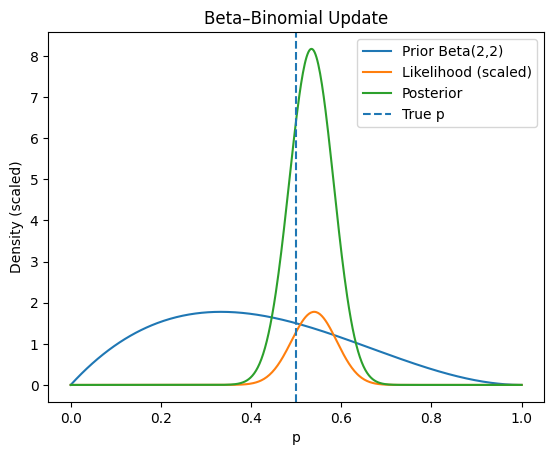

/tmp/ipykernel_36/1464608542.py:34: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(k, pp, use_line_collection=True)


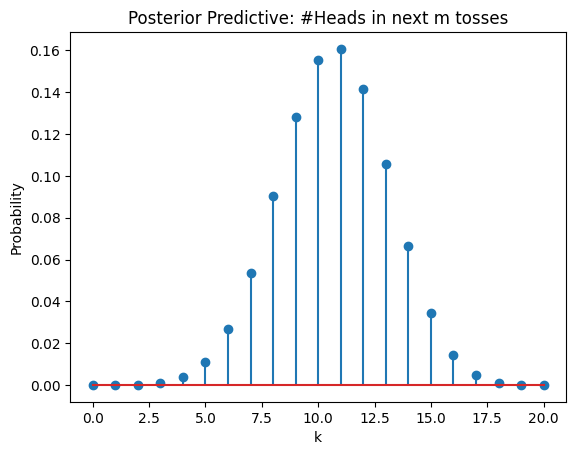

In [10]:
alpha_prior, beta_prior = 2., 3.
n, p_true = 100, 0.5
heads = np.random.binomial(n, p_true)
alpha_post = alpha_prior + heads
beta_post = beta_prior + (n - heads)

print(f'Observed heads: {heads}/{n}')
print(f'Posterior: Beta({alpha_post:.1f}, {beta_post:.1f})')

# Plot prior, likelihood (scaled), posterior
x = np.linspace(0, 1, 500)
prior = stats.beta.pdf(x, alpha_prior, beta_prior)
lik   = stats.binom.pmf(heads, n, x)  # likelihood as a function of p
lik   = lik / lik.max() * prior.max() # rescale for display
post  = stats.beta.pdf(x, alpha_post, beta_post)

plt.figure()
plt.plot(x, prior, label='Prior Beta(2,2)')
plt.plot(x, lik, label='Likelihood (scaled)')
plt.plot(x, post, label='Posterior')
plt.axvline(p_true, linestyle='--', label='True p')
plt.title('Beta–Binomial Update')
plt.xlabel('p')
plt.ylabel('Density (scaled)')
plt.legend()
plt.show()

# Posterior predictive for next m tosses: Beta-Binomial
m = 20
k = np.arange(m+1)
pp = stats.betabinom.pmf(k, m, alpha_post, beta_post)

plt.figure()
plt.stem(k, pp, use_line_collection=True)
plt.title('Posterior Predictive: #Heads in next m tosses')
plt.xlabel('k')
plt.ylabel('Probability')
plt.show()

### 2B. Normal–Normal: Bayesian mean estimation with known variance
We estimate the mean of a Gaussian with known variance and visualize prior → posterior → posterior predictive.

Posterior mu ~ N(1.186, 0.113^2)


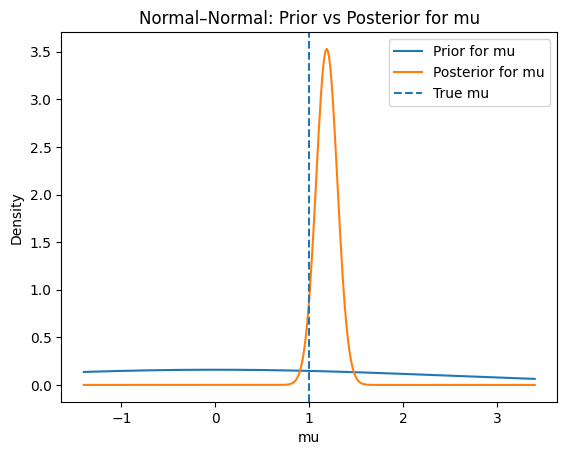

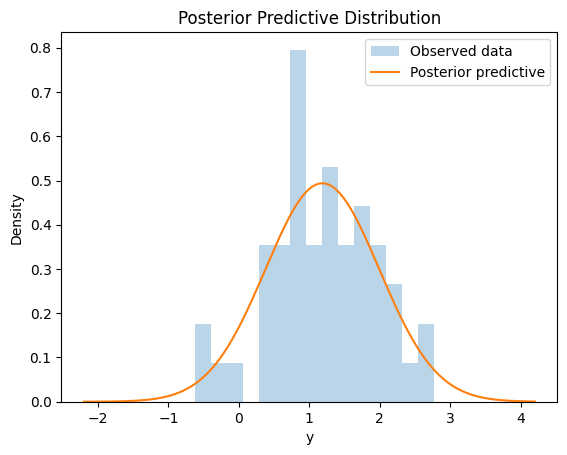

In [11]:
mu_true, sigma = 1.0, 0.8
n = 50
data = np.random.normal(mu_true, sigma, size=n)
xbar = data.mean()

# Prior on mu: Normal(mu0, tau0^2)
mu0, tau0 = 0.0, 2.5
post_var = 1 / (1/tau0**2 + n/sigma**2)
post_mean = post_var * (mu0/tau0**2 + n*xbar/sigma**2)

print(f'Posterior mu ~ N({post_mean:.3f}, {np.sqrt(post_var):.3f}^2)')

# Plot prior and posterior for mu
xs = np.linspace(mu_true-3*sigma, mu_true+3*sigma, 400)
plt.figure()
plt.plot(xs, stats.norm.pdf(xs, mu0, tau0), label='Prior for mu')
plt.plot(xs, stats.norm.pdf(xs, post_mean, np.sqrt(post_var)), label='Posterior for mu')
plt.axvline(mu_true, linestyle='--', label='True mu')
plt.title('Normal–Normal: Prior vs Posterior for mu')
plt.xlabel('mu')
plt.ylabel('Density')
plt.legend()
plt.show()

# Posterior predictive for a new observation y_new: Normal(post_mean, sigma^2 + post_var)
pred_var = sigma**2 + post_var
ys = np.linspace(mu_true-4*sigma, mu_true+4*sigma, 400)
plt.figure()
plt.hist(data, bins=15, density=True, alpha=0.3, label='Observed data')
plt.plot(ys, stats.norm.pdf(ys, post_mean, np.sqrt(pred_var)), label='Posterior predictive')
plt.title('Posterior Predictive Distribution')
plt.xlabel('y')
plt.ylabel('Density')
plt.legend()
plt.show()

## Part 3 — Cosmology Example: Inferring $H_0$ from Noisy Low-$z$ Observations

We simulate a small set of low-redshift observations. For sufficiently small $z$, Hubble's law gives $v \approx c z \approx H_0 d$, where $d$ is distance. We'll assume we have rough **standard candle** distances $d_i$ with small measurement error, and measured recession velocities $v_i$ with uncertainties. We'll infer $H_0$ using a simple Bayesian model:

$$ v_i \sim \mathcal{N}(H_0\, d_i, \sigma_v^2). $$

We place a weakly informative prior on $H_0$, e.g., $H_0 \sim \mathcal{N}(70, 20^2)$ km/s/Mpc. This is only for demonstration and not a replacement for full cosmological analyses.

Posterior for H0 ~ N(59.80, 0.27^2) km/s/Mpc


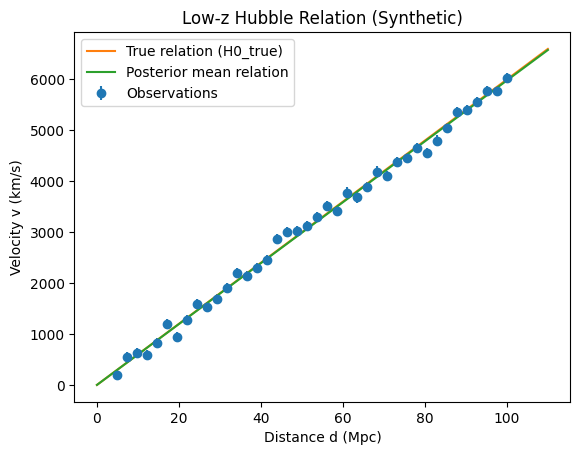

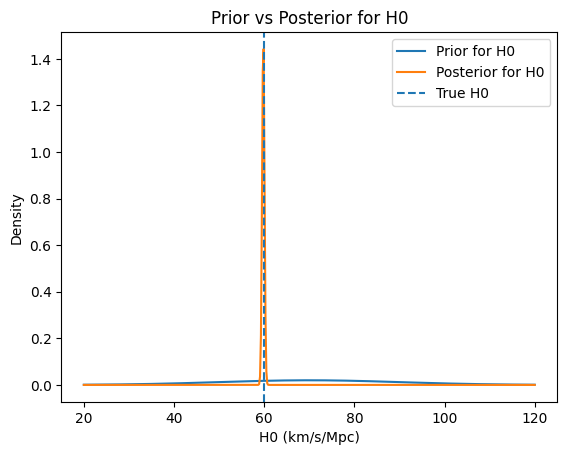

Predict v at d=10.0 Mpc: 598.0 ± 100.0 km/s (posterior predictive 1-sigma)
Predict v at d=50.0 Mpc: 2990.2 ± 100.9 km/s (posterior predictive 1-sigma)
Predict v at d=100.0 Mpc: 5980.4 ± 103.5 km/s (posterior predictive 1-sigma)


In [12]:
# Generate synthetic low-z observations
H0_true = 60.0  # km/s/Mpc
np.random.seed(123)
N = 40
d = np.linspace(5, 100, N)                 # distances in Mpc
sigma_v = 100.0                             # measurement noise (km/s)
v = H0_true * d + np.random.normal(0, sigma_v, size=N)

# Prior on H0: Normal(mu0, tau0^2)
mu0, tau0 = 70.0, 20.0

# Likelihood: v_i ~ N(H0 * d_i, sigma_v^2)
# Posterior for H0 is Normal with closed form (linear Gaussian model with known variance):
#   post_var = 1 / (1/tau0^2 + sum(d_i^2) / sigma_v^2)
#   post_mean = post_var * (mu0/tau0^2 + sum(d_i * v_i) / sigma_v^2)
post_var = 1.0 / (1.0/tau0**2 + np.sum(d**2) / sigma_v**2)
post_mean = post_var * (mu0/tau0**2 + np.sum(d * v) / sigma_v**2)

print(f'Posterior for H0 ~ N({post_mean:.2f}, {np.sqrt(post_var):.2f}^2) km/s/Mpc')

# Visualization: data and posterior for H0
plt.figure()
plt.errorbar(d, v, yerr=sigma_v, fmt='o', label='Observations')
x_line = np.linspace(0, 110, 200)
plt.plot(x_line, H0_true * x_line, label='True relation (H0_true)')
plt.plot(x_line, post_mean * x_line, label='Posterior mean relation')
plt.xlabel('Distance d (Mpc)')
plt.ylabel('Velocity v (km/s)')
plt.title('Low-z Hubble Relation (Synthetic)')
plt.legend()
plt.show()

hs = np.linspace(20, 120, 500)
plt.figure()
plt.plot(hs, stats.norm.pdf(hs, mu0, tau0), label='Prior for H0')
plt.plot(hs, stats.norm.pdf(hs, post_mean, np.sqrt(post_var)), label='Posterior for H0')
plt.axvline(H0_true, linestyle='--', label='True H0')
plt.xlabel('H0 (km/s/Mpc)')
plt.ylabel('Density')
plt.title('Prior vs Posterior for H0')
plt.legend()
plt.show()

# Posterior predictive: predict v at new distances d_new
d_new = np.array([10, 50, 100])
# y_new | H0 ~ N(H0 d_new, sigma_v^2); marginalize H0 -> Normal with variance sigma_v^2 + d_new^2 * post_var
pred_means = post_mean * d_new
pred_stds  = np.sqrt(sigma_v**2 + (d_new**2) * post_var)
for di, m, s in zip(d_new, pred_means, pred_stds):
    print(f'Predict v at d={di:.1f} Mpc: {m:.1f} ± {s:.1f} km/s (posterior predictive 1-sigma)')

Exercises (add your code below):